## **Identifying Malaria Parisites by using Deep Learning**

## **Problem definition**

Malaria is a life-threatening disease caused by parasites that are transmitted to people through the bites of infected Female Anopheles Mosquitoes. Diiagnosis of Malaria is sensitive,  laborious and sometimes unreliable especially in case of lack of expertise. In response to this problem, this project tries to identify and classify malaria on blood smear slide images by using  deep learning methodologies with the aim of automating the process.

## **Data source**

The Malaria [Dataset](ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip) used in this project is collected by researchers at the Lister Hill National Center for Biomedical Communications (LHNCBC), which contains a total of 27,558 cell images from the blood smear slide images of segmented cells. Then, these images were manually annotated as healthy and infected blood smear images by domain experts.

## **Import libraries and read data**

In [ ]:
# import all the required libraries
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix,plot_confusion_matrix, classification_report

from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten,Dense,Conv2D,MaxPool2D,Dropout
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D, MaxPool2D,Dropout
# %matplotlib inline

In [ ]:
# A function to plot loss and accuracy
def viz_history(history):
  df=pd.DataFrame(history.history)
  df[['loss','val_loss']].plot(figsize=(10,8))
  df[['accuracy', 'val_accuracy']].plot(figsize=(10,8))

To access the data set and train it with a deep learning model, first we need to upload them on google drive and access them by mounting the drive to google collab.

In [ ]:
# Mount google drive to google colab
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


First, let us see the number of blood films (images) in each class in the dataset.

In [ ]:
# Count number of images in each class 

source = os.path.join('/content/drive/MyDrive/cell_images')
parasitized_path = os.path.join(source,'Parasitized')
uninfected_path = os.path.join(source,'Uninfected')

positive_samples = glob.glob(parasitized_path+'/*.png')
negative_samples = glob.glob(uninfected_path+'/*.png')
print(" Number of Parasitized Cells Images: ",len(positive_samples))
print(" Number of Un-infected Cells Images: ",len(negative_samples))

 Number of Parasitized Cells Images:  13805
 Number of Un-infected Cells Images:  13779


## **Image pre_processing and building the dataset**

Our Malaria image dataset consists of 27,584 images with variable image dimensions. Due to computational constraints, we have decided to resize each image to a smaller size 64X64 pixels.



In [ ]:
# Setting image processing parameters
img_width=64
img_height=64
batch_size=32
nb_epoch = 20
input_shape=(img_width,img_height,3)

At this step, we will scale, split in to training and testing sets; as well as load our deep learning malaria blood smear image dataset in batches. 

In [ ]:
datagen=ImageDataGenerator(rescale=1/255.0,validation_split=0.2)

In [ ]:
# Building training image dataset
train_data_generator=datagen.flow_from_directory(directory="/content/drive/MyDrive/cell_images",
                                                 target_size=(img_width,img_height),
                                                 class_mode='binary',
                                                 batch_size=batch_size,
                                                 subset='training'
                                                 )

Found 22068 images belonging to 2 classes.


In [ ]:
# Building testing image dataset

test_data_generator=datagen.flow_from_directory(directory="/content/drive/MyDrive/cell_images",
                                                 target_size=(img_width,img_height),
                                                 class_mode='binary',
                                                 batch_size=batch_size,
                                                 subset='validation',
                                                 )

Found 5516 images belonging to 2 classes.


Now, this is the time to plot sample images to see if classes are properly labeled and the data is ready for model training. 

In [ ]:
train_data_generator.image_shape

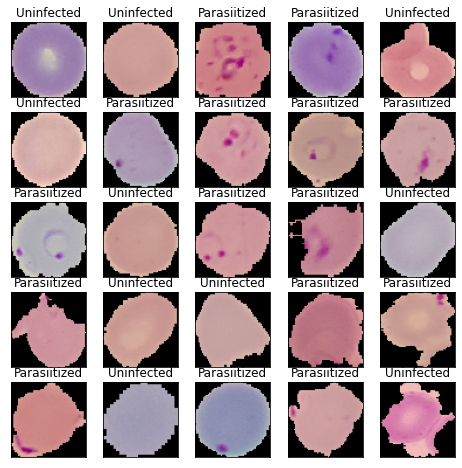

In [ ]:
# Plot images

labels=['Parasiitized','Uninfected']
x, y = train_data_generator.next()

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(25):
    n += 1 
    plt.subplot(5, 5 , n)
    plt.imshow(x[i])
    plt.xticks([])
    plt.yticks([])
    label=y[i].astype(int)
    plt.title('{}'.format(labels[label]))
  

## **Model building and training**


For this project, we will be evaluating two models, Artificial Neural Network and a Convolutional Neural Network, to classify the cell images. During the training phase, we will use our data to incrementally improve our model’s ability to predict whether a given cell image is parasitized or uninfected.

***Using Artificial Neural Network***

A three-layer ANN model with 128, 64, and 1 neurons in the layers will be implemented by using the ReLU activation function for each layer.

In [ ]:
output_dim = nb_classes = 1
# nb_epoch = 20
# flatten the image
model_ann = Sequential()

model_ann.add(Flatten(input_shape=(64,64,3)))
# our first dense layer
model_ann.add(Dense(128, input_shape=(4096,), activation="relu"))
# our second dense layer
model_ann.add(Dense(64, activation="relu"))
# last layer is the output layer.
model_ann.add(Dense(1, activation="sigmoid"))

model_ann.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_ann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12288)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1572992   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,581,313
Trainable params: 1,581,313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile model
model_ann.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Save log into history
history_ann = model_ann.fit(train_data_generator,
                              steps_per_epoch = len(train_data_generator),
                              epochs = 15,
                              validation_data = test_data_generator,
                              validation_steps =len(test_data_generator))

Epoch 1/15
690/690 [==============================] - 7449s 11s/step - loss: 0.8459 - accuracy: 0.5838 - val_loss: 0.7060 - val_accuracy: 0.5611
Epoch 2/15
690/690 [==============================] - 60s 88ms/step - loss: 0.6295 - accuracy: 0.6464 - val_loss: 0.6241 - val_accuracy: 0.6619
Epoch 3/15
690/690 [==============================] - 59s 86ms/step - loss: 0.6285 - accuracy: 0.6501 - val_loss: 0.6619 - val_accuracy: 0.5607
Epoch 4/15
690/690 [==============================] - 58s 84ms/step - loss: 0.6212 - accuracy: 0.6515 - val_loss: 0.6396 - val_accuracy: 0.6062
Epoch 5/15
690/690 [==============================] - 56s 81ms/step - loss: 0.6038 - accuracy: 0.6714 - val_loss: 0.6574 - val_accuracy: 0.5950
Epoch 6/15
690/690 [==============================] - 55s 80ms/step - loss: 0.6026 - accuracy: 0.6714 - val_loss: 0.6112 - val_accuracy: 0.6574
Epoch 7/15
690/690 [==============================] - 53s 77ms/step - loss: 0.5916 - accuracy: 0.6845 - val_loss: 0.6048 - val_accuracy

In [ ]:
viz_history(history_ann)

In [ ]:
# create a dataframe 
df = pd.DataFrame(history_ann.history)
print("ANN training summary")
df.head()

ANN training summary


,loss,accuracy,val_loss,val_accuracy
0,0.691063,0.614057,0.705966,0.561095
1,0.631311,0.642605,0.624126,0.661893
2,0.622005,0.653888,0.661942,0.560732
3,0.612076,0.660187,0.639617,0.606236
4,0.604700,0.668343,0.657410,0.594996


In [ ]:
# Model accuracy on the test data
score_ann = model_ann.evaluate(test_data_generator, verbose = 0) 

print('Test loss:', score_ann[0]) 
print('Test accuracy:', score_ann[1])

Test loss: 0.6787750720977783
Test accuracy: 0.5578317642211914


***Using Convolutional Neural Network (CNN)***

In [ ]:
# Building CNN model
model=Sequential()

# first convolution layer with 128 filters with 3x3 size
model.add(Conv2D(16,(3,3),input_shape=input_shape,activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

# first convolution layer with 32 filters with 3x3 size
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3)) # use dropout for regularization

# first convolution layer with 64 filters with 3x3 size
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2,2)) # reduce dimensions using a max pooling size 2x2
model.add(Dropout(0.3))

# flatten the image
model.add(Flatten())

# build vanilla nn
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

# output layer
model.add(Dense(1,activation='sigmoid'))

In [ ]:
# Display architecture
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 64)       

This is step is compiling model by defining the loss function, the optimizer and the metrics.

In [ ]:
# Compile model
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Save log into history
history = model.fit(train_data_generator,
                              steps_per_epoch = len(train_data_generator),
                              epochs = 15,
                              validation_data = test_data_generator,
                              validation_steps =len(test_data_generator))

In [ ]:
# create a dataframe 
df = pd.DataFrame(history.history)
print("CNN training summary")
df.tail()

CNN training summary


,loss,accuracy,val_loss,val_accuracy
10,0.120776,0.960304,0.147450,0.949239
11,0.122383,0.959987,0.149956,0.946701
12,0.117280,0.960123,0.148384,0.951051
13,0.117563,0.961030,0.153325,0.949964
14,0.114936,0.961483,0.144769,0.949420


Let us see the accuracy of our model on the test data.


In [ ]:
# Model accuracy on the test data
score = model.evaluate(test_data_generator, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.1447693556547165
Test accuracy: 0.9494198560714722


Let us visualize the loss and accuracy for both in-sample and out-sample data in order to see convergence information over epochs as well as if model is overlearning during the training process.  

In [ ]:
# Plot loss and accuracy
def viz_history(history):
  df=pd.DataFrame(history.history)
  df[['loss','val_loss']].plot(figsize=(20,20))
  df[['accuracy', 'val_accuracy']].plot(figsize=(20,10))

In [ ]:
viz_history(history)

From the plot of loss and accuracy, we can see that the model may not perform well if the no epochs are increased as the loss started invreaseing for the out-sample around the 4th epoch. 

In [ ]:
# Save model
model.save('mal_detect1.h5')

Here, we will be saving our model, which means, the architecture of the model, the weights of the model, the training configuration, as well as the state of the optimizer to allow easy resumption from where we left-of.

## **Model Prediction and Evaluation**

The last step is to see the preformance of the model. In ordert to do this, we will predict the out-of-sample data that was not used during the training phase. If a new sample is to be used, the saved model will be loaded and used for making predictions. 

In [ ]:
# Load previously saved model
model = load_model('/content/mal_detect1.h5')
# predictions = np.argmax(model.predict(validation_data_generator), axis=1)

***Using ANN***

In [ ]:
# Make Predictions on Test Data
pred_ann = model_ann.predict(test_data_generator)

In [ ]:
y_true_labels = test_data_generator.labels
report_ann = classification_report(y_true_labels, pred_ann.round())
cm_ann = confusion_matrix(y_true_labels, pred_ann.round())

In [ ]:
# Classifiction report - ANN
print(report_ann)


              precision    recall  f1-score   support

           0       0.53      0.98      0.69      2761
           1       0.86      0.14      0.24      2755

    accuracy                           0.56      5516
   macro avg       0.70      0.56      0.46      5516
weighted avg       0.70      0.56      0.46      5516



Text(0.5, 1.0, 'Confusion Matrix - ANN')

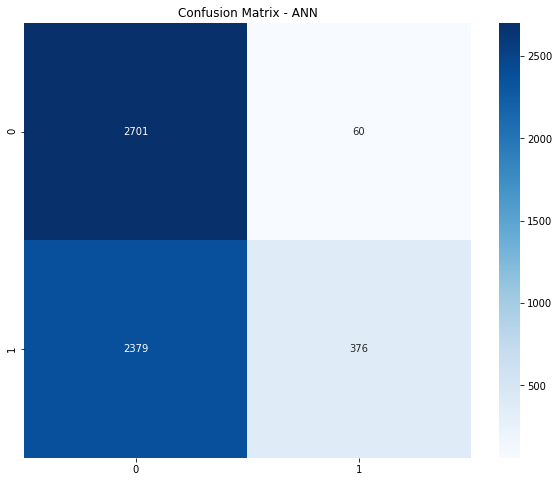

In [ ]:
# Confusion Matrix - ANN
plt.figure(figsize=(10,8))
sns.heatmap(cm_ann, annot=True, fmt='.0f', cmap='Blues')
plt.title('Confusion Matrix - ANN')

To test the performance of the model, we will be using confusion matrix and/or precision & recall. There are 5516 total samples in the test set. Looking at the confusion matrix, we can see that the model accurately predicted 3077 out of 5516 samples, whereas incorrectly predicted 2439 of them.

***Using CNN***

In [ ]:
# Make Predictions on Test Data
pred = model.predict(test_data_generator)

In [ ]:
y_true_labels = test_data_generator.labels
report = classification_report(y_true_labels, pred.round())
cm = confusion_matrix(y_true_labels, pred.round())

In [ ]:
# Classification report - CNN
print(report)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2761
           1       0.94      0.96      0.95      2755

    accuracy                           0.95      5516
   macro avg       0.95      0.95      0.95      5516
weighted avg       0.95      0.95      0.95      5516



Looking at the confusion matrix, we can see that the model accurately predicted 5237 out of 5516 samples, whereas incorrectly predicted 279 of them.


Text(0.5, 1.0, 'Confusion Matrix - CNN')

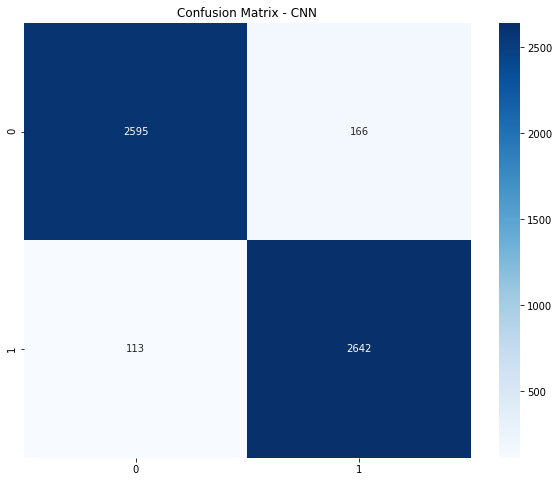

In [ ]:
# Confusion matrix - CNN
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues')
plt.title('Confusion Matrix - CNN')

## **Conclusion**

In this project, ANN and CNN have been evaluated for detecting malaria parasites from a given dataset of blood films that contain infected and uninfected cells. CNN performed pretty well with a 95% accuracy and f1-score, whereas ANN is able to detect only 56%. Computational complexity has been seen to be one of the most challanging part in this project, however, the CNN model can be further improved by using more training datasets or augumenting the existing ones as well as tuning more parameters which couldn't be done exhaustively due to time constraint.

**Remark**
- Three activation functions: Relu, tanh, and sigmoid have been compared and ReLU performed well. In addition adam and sgd have also been compared and adam is found to be a better optimizer .
- Different no epochs, batch-size, and learning-rates have been checked. 
* For brevity, only parameters that help the model converge and give better results have been implemented.